In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

from skimage.io import imread
from skimage.transform import resize
# from scipy.misc import imresize

In [2]:
img_size = 200

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

In [4]:
gd = tf.GraphDef()
with open("truncated.pb", 'rb') as f:
    gd.ParseFromString(f.read())
    
tf.import_graph_def(gd, name="vgg")

In [5]:
input_image = tf.get_default_graph().get_tensor_by_name("vgg/images:0")

In [6]:
layers = ['vgg/conv1_1/conv1_1', 'vgg/conv1_2/conv1_2', 'vgg/conv2_1/conv2_1', 'vgg/conv2_2/conv2_2', 'vgg/conv3_1/conv3_1']

def get_layers(indexes):
    ls = []
    
    for i in indexes:
        ls.append( tf.get_default_graph().get_tensor_by_name(layers[i] + ":0"))
        
    return ls

def create_feed_dict(img):
    return {input_image: np.expand_dims(img, axis=0)}

In [7]:
def load_image(filname, size=None):
    img = imread(filname).astype(float)[:,:,:3]
    if size is not None:
        img = resize(img, size)
    return img

def load_mask(filname, size=None):
    return load_image(filname, size)[:,:,-1]

In [8]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

In [9]:
def create_content_loss(content_image, layer_ids):
    feed_dict = create_feed_dict(content_image)

    layers = get_layers(layer_ids)

    values = sess.run(layers, feed_dict=feed_dict)

    layer_losses = []
    
    for value, layer in zip(values, layers):
        value_const = tf.constant(value)
        loss = mean_squared_error(layer, value_const)
        layer_losses.append(loss)

    total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [10]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    num_channels = int(shape[-1])
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    gram = tf.matmul(tf.transpose(matrix), matrix)
    return gram

In [11]:
def create_single_style_loss(style_image, layer_ids, mask_image=None):
    feed_dict = create_feed_dict(style_image)
    layers = get_layers(layer_ids)
    
    gram_layers = [gram_matrix(layer) for layer in layers]
    values = session.run(gram_layers, feed_dict=feed_dict)

    layer_losses = []
    
    for value, gram_layer in zip(values, gram_layers):
        value_const = tf.constant(value)

        loss = mean_squared_error(gram_layer, value_const)

        layer_losses.append(loss)

    total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss, values

In [12]:
def mask_to_segments(flatten_mask):
    segments = []
    start = None
    
    for i, val in enumerate(flatten_mask):
        if val > 0.5:
            if start is None:
                start = i
        else:
            if start is not None:
                segments.append((start, i - start))
                start = None
    
    if start is not None:
        segments.append((start, i + 1 - start))
        
    return segments        

In [13]:
def create_masked_style_loss(style_image, layer_ids, mask):
    style_feed = create_feed_dict(style_image)
    mask_feed = create_feed_dict(np.stack([mask, mask, mask], axis=2))
    
    layers = get_layers(layer_ids)
    
    gram_layers = [gram_matrix(layer) for layer in layers]
    values = sess.run(gram_layers, feed_dict=style_feed)
        
    layer_sizes = list(map(lambda l: l.shape[1:3], sess.run(layers, feed_dict=mask_feed)))
                
    layer_masks = [resize(mask, size).reshape([-1]) for size in layer_sizes]
    mask_segments = [mask_to_segments(layer_mask) for layer_mask in layer_masks]
        
    layer_losses = []
    
    for style_gram, layer, segments in zip(values, layers, mask_segments):
        style_const = tf.constant(style_gram)
            
        num_channels = int(layer.get_shape()[-1])
            
        flatten_layer = tf.reshape(layer, [-1, num_channels])
                
        parts = [tf.slice(flatten_layer, [start, 0], [size, num_channels]) for (start, size) in segments]
            
        masked = tf.concat(parts, axis=0)
            
        loss = mean_squared_error(gram_matrix(masked), style_const)

        layer_losses.append(loss)

    total_loss = tf.reduce_mean(layer_losses)/(mask.shape[0]*mask.shape[1]/mask.sum())
        
    return total_loss

In [14]:
def create_denoise_loss():
    loss = tf.reduce_sum(tf.abs(input_image[:,1:,:,:] - input_image[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(input_image[:,:,1:,:] - input_image[:,:,:-1,:]))

    return loss

In [32]:
style1 = load_image("mel.jpg", (img_size, img_size))
style2 = load_image("wallpaper1.jpg", (img_size, img_size))

content_filename = 'live_tests/part_image.png'
content_image = load_image(content_filename, (img_size, img_size))

wallpaper_mask = load_mask("live_tests/wallpaper_mask.png", (img_size, img_size))
sofa_mask = load_mask("live_tests/sofa_mask.png", (img_size, img_size))

/home/alexander/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [16]:
content_layer_ids = [4]
style_layer_ids = list(range(3))
weight_content=1.5
weight_style=10.0
weight_denoise=0.3
num_iterations=40
step_size=10.0

In [17]:
loss_content = create_content_loss(content_image=content_image,
                                   layer_ids=content_layer_ids)

loss_style1 = create_masked_style_loss(style_image=style2,
                                layer_ids=[4],
                                mask=wallpaper_mask)

loss_style2 = create_masked_style_loss(style_image=style1,
                               layer_ids=[1, 2, 3, 4],
                               mask=sofa_mask)

loss_denoise = create_denoise_loss()

adj_content = tf.Variable(1e-10, name='adj_content')
adj_style1 = tf.Variable(1e-10, name='adj_style1')
adj_style2 = tf.Variable(1e-10, name='adj_style2')
adj_denoise = tf.Variable(1e-10, name='adj_denoise')

sess.run([adj_content.initializer,
             adj_style1.initializer,
              adj_style2.initializer,
             adj_denoise.initializer])

update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
update_adj_style1 = adj_style1.assign(1.0 / (loss_style1 + 1e-10))
update_adj_style2 = adj_style1.assign(1.0 / (loss_style2 + 1e-10))
update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

loss_combined = weight_content * adj_content * loss_content + \
    weight_style * adj_style1 * loss_style1 + \
    weight_style * adj_style2 * loss_style2 + \
    weight_denoise * adj_denoise * loss_denoise

gradient = tf.gradients(loss_combined, input_image)

run_list = [gradient, update_adj_content, update_adj_style1, update_adj_style2, \
            update_adj_denoise]

/home/alexander/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


. 
Iteration: 0


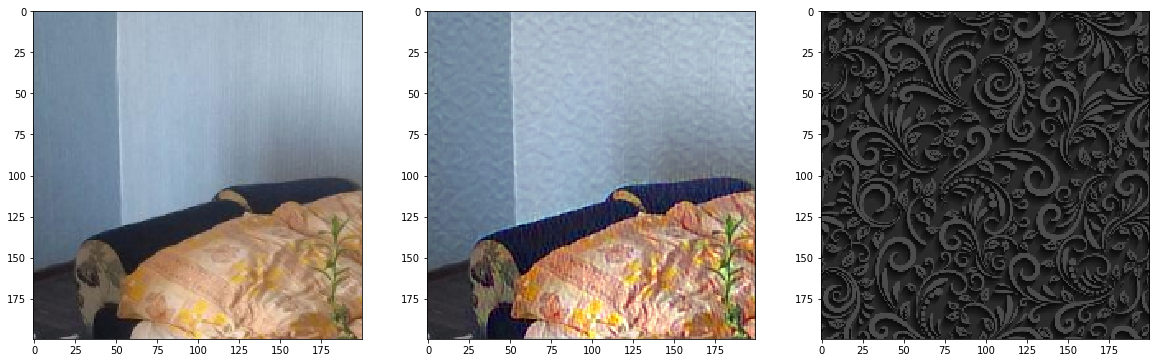

. . . . . . . . . . . . . . . . . . . . 
Iteration: 20


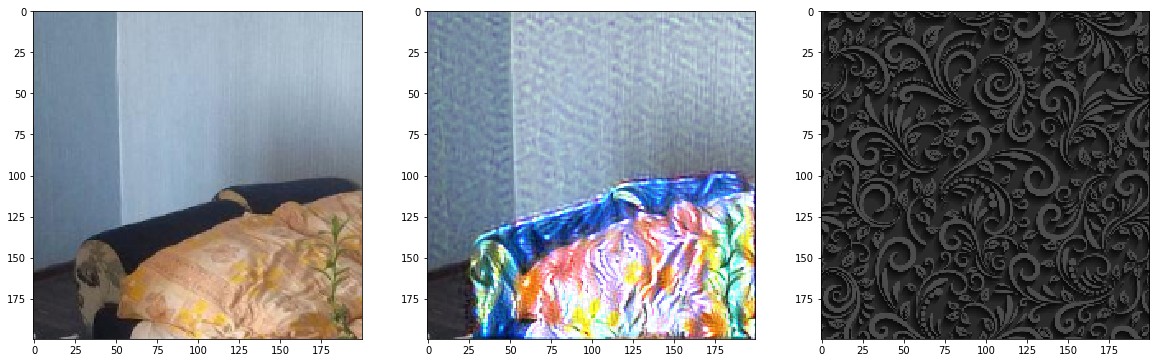

. . . . . . . . . . . . . . . . . . . 
Iteration: 39


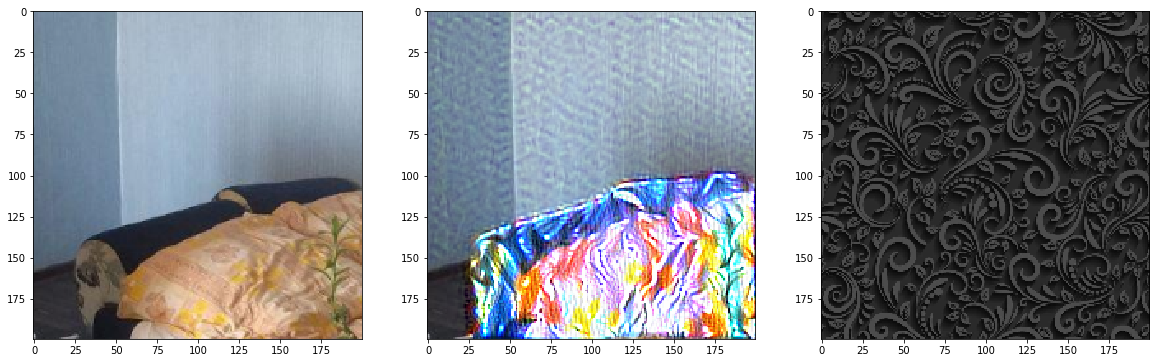

In [18]:
mixed_image = content_image.copy().astype(float)

for i in range(num_iterations):
    feed_dict = create_feed_dict(mixed_image)

    grad, adj_content_val, adj_style_val1, adj_style2_val, adj_denoise_val \
        = sess.run(run_list, feed_dict=feed_dict)

    grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
    step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
#     mixed_image[np.where(content_mask == 1.0)] -= (grad * step_size_scaled)[np.where(content_mask == 1.0)]
    mixed_image -= (grad * step_size_scaled)

        # Ensure the image has valid pixel-values between 0 and 255.
    mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
    print(". ", end="")

        # Display status once every 10 iterations, and the last.
    if (i % 20 == 0) or (i == num_iterations - 1):
        print()
        print("Iteration:", i)

            # Print adjustment weights for loss-functions.
#         msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
#         print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

        fig = plt.figure(figsize=(20,20))
        fig.add_subplot(1, 3, 1)
        plt.imshow(content_image/256)
        fig.add_subplot(1, 3, 2)
        plt.imshow(mixed_image/256)
        fig.add_subplot(1, 3, 3)
        plt.imshow(style2/256)
        plt.show()

<h1>Smart selection</h1>

In [27]:
layer = get_layers([0])[0]
layer_gram = gram_matrix(layer)

In [28]:
def style_angle(gram1, gram2):
    gram1 = gram1.flatten()
    gram2 = gram2.flatten()
    gram1_length = np.sqrt(np.dot(gram1, gram1))
    gram2_length = np.sqrt(np.dot(gram2, gram2))
    angle_cos = np.dot(gram1, gram2)/gram1_length/gram2_length
    angle_cos = np.clip(angle_cos, 0.0, 1.0)
    return np.arccos(angle_cos)
    

59


(1, 590, 590, 64)

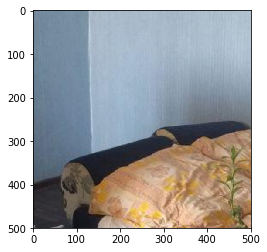

In [33]:
# content_image = load_image('/home/alexander/Downloads/Telegram Desktop/photo_2018-05-16_17-31-26.jpg', (200, 200))
plt.imshow(content_image/256)

side = 15
stride = 10

padded = np.pad(content_image, ((side*3,side*3), (side*3,side*3), (0,0)), mode ='symmetric')

height, width, _ = padded.shape

h_s = (height)//stride
w_s = (width)//stride

print(h_s)

signature = np.zeros([h_s, w_s, 64, 64])

result_layer = sess.run(layer, feed_dict=create_feed_dict(padded))

for i in range(h_s):
    for j in range(w_s):
        patch = padded[i*stride:i*stride + side, j*stride:j*stride + side,:]
        signature[i, j] = sess.run(layer_gram, feed_dict=create_feed_dict(patch))
        
result_layer.shape

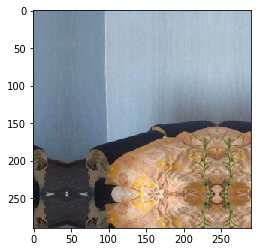

In [23]:
plt.imshow(padded/256)

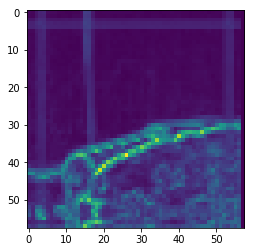

In [82]:
similarity_matrix = np.zeros([h_s - 1, w_s - 1])

for i in range(h_s - 1):
    for j in range(w_s - 2):
        similarity_matrix[i, j] =\
            style_angle(signature[i,j], signature[i+1, j+1]) + \
        style_angle(signature[i,j], signature[i, j+1]) + \
            style_angle(signature[i,j], signature[i+1, j])
            


similarity_matrix[np.isnan(similarity_matrix)] = 0.0
similarity_matrix /= 3

plt.figure()
plt.imshow(similarity_matrix)


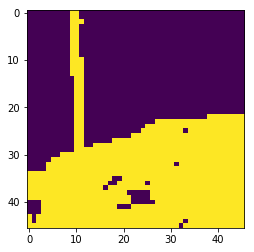

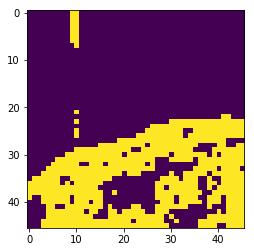

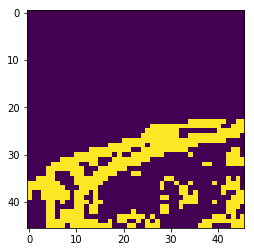

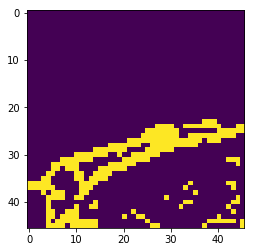

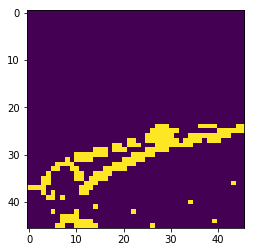

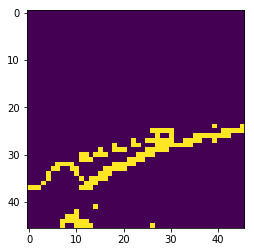

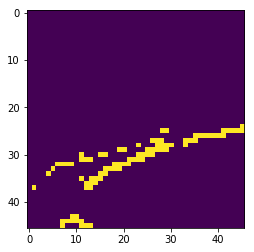

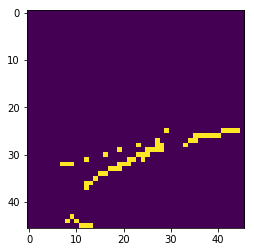

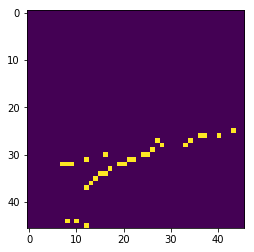

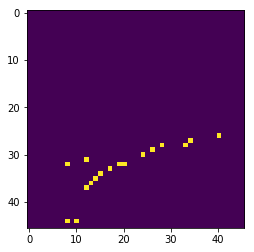

In [83]:
for i in range(10):
    plt.figure(figsize=(4,4))
    plt.imshow(np.where(similarity_matrix < (i+1)/20, 0.0, 1.0)[6:-6,6:-6])

In [ ]:
from skimage.morphology import watershed

In [ ]:
markers = np.zeros_like(similarity_matrix)
markers[10,10] = 1
markers[-40,-40] = 2


# plt.imshow(watershed(similarity_matrix, markers))

In [ ]:
similarity_matrix.max()